✅ RMSE (erro quadrático médio): 3722.55


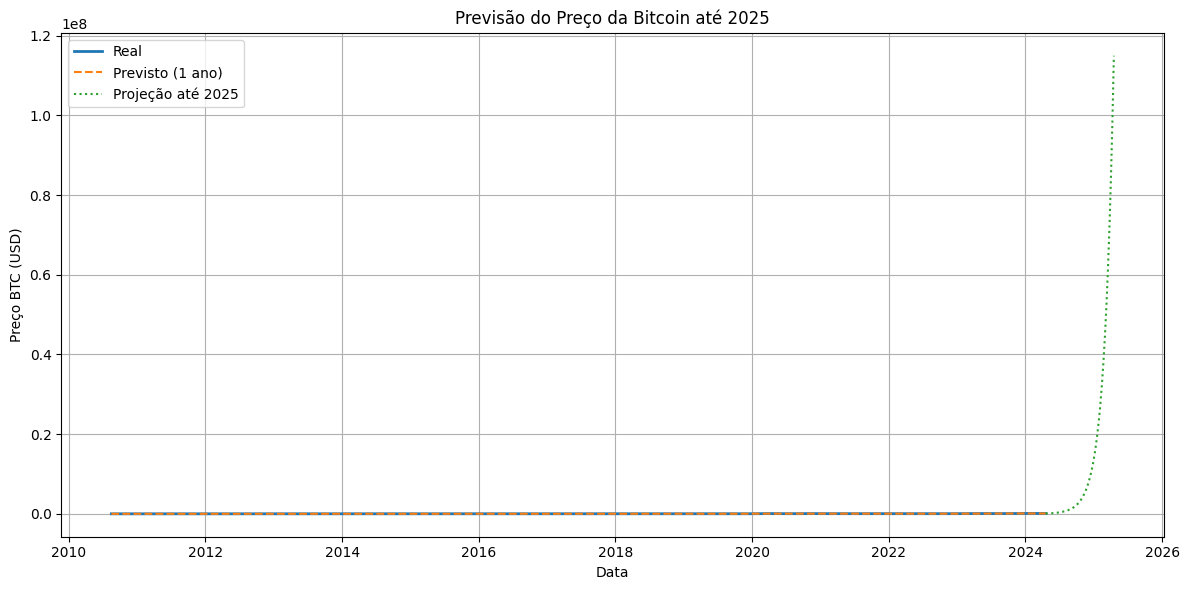

In [4]:
# 📘 Notebook: Previsão do Preço da Bitcoin (Até 2025)

# ✅ 1. Carregar dados
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, lead
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.getOrCreate()
df = spark.read.option("header", True).option("inferSchema", True).csv("../data/final_btc_ml_dataset.csv")
df = df.withColumn("Date", to_date("Date"))

# ✅ 2. Filtrar e ordenar os dados para previsão
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, lead

df = df.orderBy("Date")
df = df.withColumn("row_id", row_number().over(Window.orderBy("Date")))

# ✅ 3. Criar variável target futura (previsão de 365 dias)
df = df.withColumn("close_btc_target", lead("close_btc", 365).over(Window.orderBy("Date")))
df = df.dropna(subset=["close_btc_target"])

# ✅ 4. Selecionar features relevantes
features = [
    'open_btc', 'high_btc', 'low_btc', 'close_btc', 'volume_btc', 'block_reward', 'cpi',
    'open_sp500', 'high_sp500', 'low_sp500', 'close_sp500', 'volume_sp500',
    'SMA_20_btc', 'BB_std_btc', 'BB_upper_btc', 'BB_lower_btc', 'RSI_btc',
    'EMA_12_btc', 'EMA_26_btc', 'MACD_btc', 'MACD_signal_btc',
    'USDCHF', 'EURCHF'
]

# ✅ 5. Remover linhas com null nas features ou na target
df = df.dropna(subset=features + ["close_btc_target"])

# ✅ 6. Preparar dados para modelagem
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(df).select("Date", "features", "close_btc_target")

# ✅ 7. Dividir treino/teste
train, test = data.randomSplit([0.8, 0.2], seed=42)

# ✅ 8. Treinar modelo
rf = RandomForestRegressor(labelCol="close_btc_target", featuresCol="features", numTrees=100)
model = rf.fit(train)

# ✅ 9. Avaliar
predictions = model.transform(test)
evaluator = RegressionEvaluator(labelCol="close_btc_target", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"✅ RMSE (erro quadrático médio): {rmse:.2f}")

# ✅ 10. Visualizar previsões para 2025 (1 ano de previsão)
pdf_1_year = predictions.select("Date", "close_btc_target", "prediction").toPandas().sort_values("Date")

# ✅ 11. Projeção futura até 2025 (Extrapolar com tendência)
# Pegar na última data do dataframe e criar novas datas até 2025
last_date = df.select("Date").toPandas().tail(1)['Date'].values[0]

# Estimativa de crescimento do preço da Bitcoin (simulação de 2% por ano)
extended_dates = pd.date_range(last_date, periods=365, freq='D')

# Criar um DataFrame com as datas futuras
future_df = pd.DataFrame({'Date': extended_dates})
future_df['close_btc_target'] = None  # Placeholder para a previsão

# Estimar o comportamento (crescimento simples de 2% por ano)
for i in range(365):
    future_df.loc[i, 'close_btc_target'] = future_df.loc[i-1, 'close_btc_target'] * (1 + 0.02) if i > 0 else pdf_1_year['close_btc_target'].iloc[-1]

# ✅ 12. Visualizar as previsões
plt.figure(figsize=(12, 6))
plt.plot(pdf_1_year["Date"], pdf_1_year["close_btc_target"], label="Real", linewidth=2)
plt.plot(pdf_1_year["Date"], pdf_1_year["prediction"], label="Previsto (1 ano)", linestyle="--")
plt.plot(future_df["Date"], future_df["close_btc_target"], label="Projeção até 2025", linestyle=":")
plt.title("Previsão do Preço da Bitcoin até 2025")
plt.xlabel("Data")
plt.ylabel("Preço BTC (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
